In [1]:
import argparse
import numpy as np
import scipy.io as sio
import math as mt
from scipy.fftpack import fft
from scipy.fftpack import fftshift
from scipy.signal.windows import hann
import pickle
import scipy.signal as signal
import pywt
import pandas as pd
import os
import sys

In [2]:


head_movement={}

phase='phase2'
save=f'/mnt/hdd/tson/Python_code/Doppler_traces/{phase}'
ex_dir= '/mnt/hdd/WiFiTuned/Python/processed_phase'
phases= os.listdir(ex_dir)
phases.sort()
for i in phases:
    if phase in i:
        files= os.listdir(f'{ex_dir}/{i}')
        files.sort()
        for j in files: 
            file_path = f'{ex_dir}/{i}/{j}'
            with open(file_path, 'rb') as f:
                csi_buff_=pickle.load(f)
            head_movement[f'{j[:-4]}'] = csi_buff_


In [3]:
traces_activities = []
stream=0
start_plt=0

feature_length = 250
sliding = 1
Tc = 4e-3 # 10e-3
fc = 2.4e9
v_light = 3e8


end= 600
delta_v = round(v_light / (Tc * fc * feature_length), 3)
antenna = 0
for activity in list(head_movement.keys()):
    print(activity)

    sliding = 1
    noise_lev = -1.2
    num_symbols = 31  # 51
    middle = int(mt.floor(num_symbols / 2))

    fc = 2.4e9 
    v_light = 3e8

    csi_buff=head_movement[activity][0:,]
    csi_buff= csi_buff.reshape((len(csi_buff), -1))
    if csi_buff.shape[0] < num_symbols:
        pass
  
    print(csi_buff.shape, "main")

    csi_buff = pd.DataFrame(csi_buff)
    csi_buff= csi_buff.dropna()
    print(csi_buff.shape)
    csi_buff_= np.asarray(csi_buff)
    csi_matrix_processed= csi_buff_.reshape(csi_buff_.shape[0], 114, 2)
    csi_matrix_processed = csi_matrix_processed[0:-1, :, :]
  


    csi_matrix_processed[:, :, 0] = csi_matrix_processed[:, :, 0] / np.mean(csi_matrix_processed[:, :, 0],
                                                                                        axis=1,  keepdims=True)
    csi_matrix_complete = csi_matrix_processed[:, :, 0]*np.exp(1j*csi_matrix_processed[:, :, 1])

    csi_d_profile_list = []
    for k in range(0, csi_matrix_complete.shape[0]-num_symbols, sliding):
        csi_matrix_cut = csi_matrix_complete[k:k+num_symbols, :]
        csi_matrix_cut = np.nan_to_num(csi_matrix_cut)
        
        # csi_matrix_cut -= np.mean(csi_matrix_cut, axis=0, keepdims=True)
        hann_window = np.expand_dims(hann(num_symbols), axis=-1)
        csi_matrix_wind = np.multiply(csi_matrix_cut, hann_window)
        # 31 X 114
        
        csi_doppler_prof = fft(csi_matrix_wind, n=100, axis=0)
        # 100 X 114
        csi_doppler_prof = fftshift(csi_doppler_prof, axes=0)
        
        csi_d_map = np.abs(csi_doppler_prof * np.conj(csi_doppler_prof))
        
        csi_d_map = np.sum(csi_d_map, axis=1)

        csi_d_profile_list.append(csi_d_map)
    csi_d_profile_array = np.asarray(csi_d_profile_list)
    csi_d_profile_array_max = np.max(csi_d_profile_array, axis=1, keepdims=True)
    csi_d_profile_array = csi_d_profile_array/csi_d_profile_array_max
    save_name = f'{save}/{activity}.txt'
    with open(save_name, "wb") as fp:  # Pickling
        pickle.dump(csi_d_profile_array, fp)
    csi_d_profile_array[csi_d_profile_array < mt.pow(10, noise_lev)] = mt.pow(10, noise_lev)
    end_plt=csi_d_profile_array.shape[0]
    stft_sum_1_log = csi_d_profile_array[start_plt:min(csi_d_profile_array.shape[0], end_plt), :]
    print(stft_sum_1_log.shape, "log")
    stft_antennas = []
    stft_antennas.append(stft_sum_1_log)

    traces_activities.append(stft_antennas)
    end= 600
    delta_v = round(v_light / (Tc * fc * feature_length), 3)
    antenna = 0



Forward
(4000, 228) main
(4000, 228)
(3968, 100) log
Looking Down
(4000, 228) main
(4000, 228)
(3968, 100) log
Looking Left
(4000, 228) main
(4000, 228)
(3968, 100) log
Looking Right
(4000, 228) main
(4000, 228)
(3968, 100) log
Looking Up
(4000, 228) main
(4000, 228)
(3968, 100) log
Nodding
(4000, 228) main
(4000, 228)
(3968, 100) log
Shaking
(4000, 228) main
(4000, 228)
(3968, 100) log


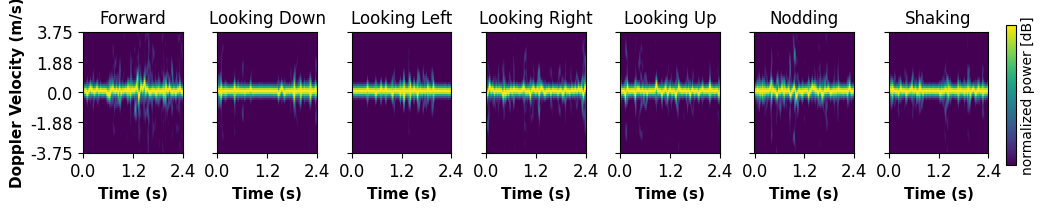

In [4]:

import argparse
import numpy as np
import pickle
from os import listdir
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plt_fft_doppler_activities_(doppler_spectrum_list, antenna, csi_label_dict, sliding_lenght, delta_v, end, name_plot, act_name):
    fig = plt.figure(constrained_layout=True)
    fig.set_size_inches(10, 2)
    widths = [1, 1, 1, 1, 1, 1,1]
    heights = [1]
    gs = fig.add_gridspec(ncols=7, nrows=1, width_ratios=widths, height_ratios=heights)
    step = 15
    step_x = 2
    ax = []
    for a_i in range(0,7):
        
        act = doppler_spectrum_list[a_i][antenna]
        act= act[:end,:]
     
        length_v = mt.floor(act.shape[1] / 2)
       
        factor_v = step * (mt.floor(length_v / step))
   
        ticks_y = np.arange(length_v - factor_v, length_v + factor_v, step)

        # ticks_y=[20,  30,  40,  50,  60,  70,  80]
        ticks_x = np.arange(0, act.shape[0] + 1, int(act.shape[0]/step_x))
 

        ax1 = fig.add_subplot(gs[(0, a_i)])
        plt1 = ax1.pcolormesh(act.T, cmap='viridis', linewidth=0, rasterized=True)  # , shading='gouraud')
        plt1.set_edgecolor('face')
   
        ax1.set_ylabel("Doppler Velocity (m/s)", fontsize=11, fontweight='bold')
        ax1.set_xlabel('Time (s)', fontsize=11, fontweight='bold')
        # ticks_y=np.arange(0,101,20)
        ax1.set_yticks(ticks_y)

        ax1.set_yticklabels(np.round((ticks_y - length_v) * delta_v, 2), fontsize=12)
        ax1.set_ylim(20,80)
        ax1.set_xticks(ticks_x+0.5)
        ax1.set_xticklabels(np.round(ticks_x * sliding_lenght * 4e-3, 2), fontsize=12)
        
        title_p = act_name[a_i]
        ax1.set_title(title_p)
        ax.append(ax1)

        if a_i == 6:
            cbar_ax = fig.add_axes([1, 0.2, 0.01, 0.7])
            cbar1 = fig.colorbar(plt1,  cax=cbar_ax, ticks=[-12, -8, -4, 0])
            cbar1.ax.set_ylabel('normalized power [dB]')

    for axi in ax:
        axi.label_outer()
  
    # plt.ylim(-4,4)
    # plt.savefig(name_plot, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


stream=0
start_plt=7500
end_plt=csi_d_profile_array.shape[0]

feature_length = 250
sliding = 1
Tc = 4e-3 # 10e-3
fc = 2.4e9
v_light = 3e8

end= 600
delta_v = round(v_light / (Tc * fc * feature_length), 3)
antenna = 0
act_name =list(head_movement.keys())
name_plot= f'/mnt/hdd/tson/Python_code/plots/{phase}_noisy.pdf'
plt_fft_doppler_activities_(traces_activities, antenna, activity, sliding, delta_v,end, name_plot,act_name)